In [1]:
import io
import os
import glob
import zipfile

import pyart
import pyodim
import pyproj
import cartopy
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as pl
import ultraplot as pplt

from numba import jit


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# cartopy.config["pre_existing_data_dir"] = "/g/data/kl02/vhl548/.local/share/cartopy/"

In [17]:
fname = "/home/vlouf/Remote/gadi/g/data/rq0/level_1/odim_pvol/66/2025/vol/66_20250305.pvol.zip"
with zipfile.ZipFile(fname) as zid:
    namelist = sorted(zid.namelist())
    content = io.BytesIO(zid.read(namelist[1]))
    for f in namelist[:3]:
        zid.extract(f, path="/tmp/")

In [4]:
rset = pyodim.read_odim(content)
radar = rset[0].compute()
lon0 = radar.attrs["longitude"]
lat0 = radar.attrs["latitude"]
date = radar.attrs["date"]
nyquist = radar.attrs['NI']

proj = pyproj.Proj(f"+proj=aeqd +lon_0={lon0} +lat_0={lat0} +units=m")
lonlims, latlims = proj((-150e3, 150e3), (-150e3, 150e3), inverse=True)

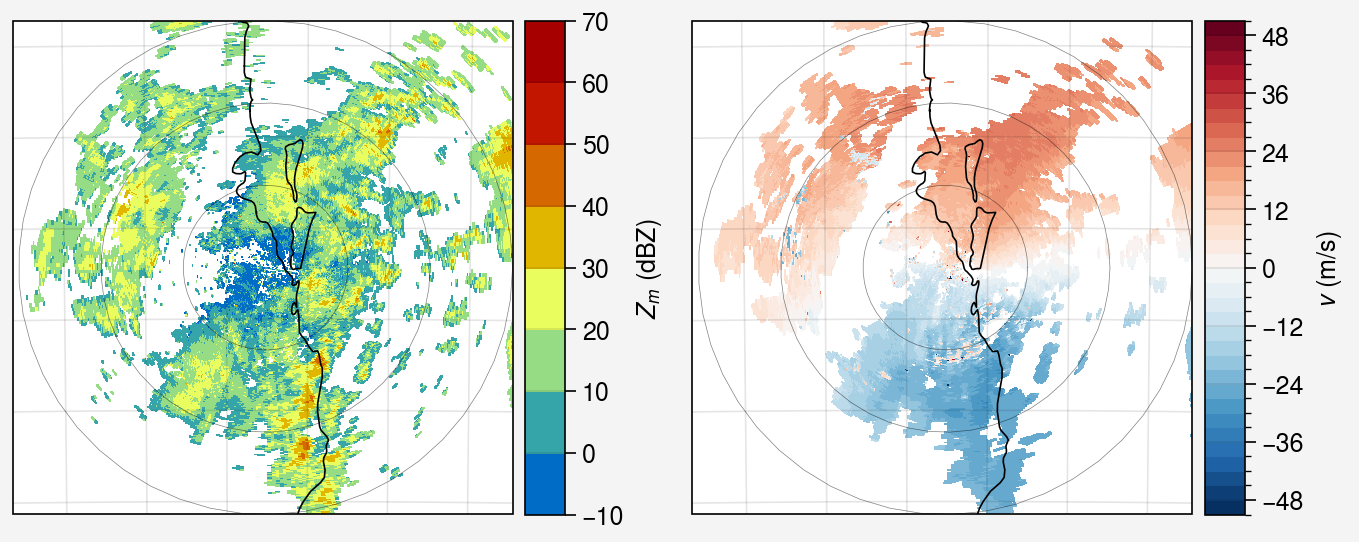

In [5]:
fig = pplt.figure()
axs = fig.subplots(nrows=1, ncols=2, proj="aeqd", proj_kw={"lon_0": lon0, "lat_0":lat0})
im = [None] * len(axs)

im[0] = axs[0].pcolormesh(radar.longitude, radar.latitude, radar.DBZH, vmin=-15, vmax=75, cmap="homeyerrainbow")
im[1] = axs[1].pcolormesh(radar.longitude, radar.latitude, np.ma.masked_less(radar.VRADDH, -120), vmin=-52, vmax=52, levels=40)
axs[0].colorbar(im[0], label="$Z_m$ (dBZ)")
axs[1].colorbar(im[1], label="$v$ (m/s)")

th = np.linspace(0, 6.28)
for r in [50e3, 100e3, 150e3]:
    x0 = r * np.cos(th)
    y0 = r * np.sin(th)
    xlo, yla = proj(x0, y0, inverse=True)
    axs.plot(xlo, yla, "k", linewidth=.25, alpha=0.5)

axs.format(
    latlim=latlims,
    lonlim=lonlims,
    coast=True,
    reso="hi",
)

pl.show()

In [6]:
def read_vad(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Skip the first two lines and the header separator line
    data_lines = lines[5:]

    # Parse the main data
    data = []
    for line in data_lines:
        values = line.split()
        if values:
            data.append([float(val) for val in values])

    # Create a DataFrame from the parsed data
    columns = ['z', 'npts', 'error', 'u0', 'v0', 'w0', 'vt', 'divergence', 'stretching', 'shearing']
    df = pd.DataFrame(data, columns=columns)    
    df.drop(columns=['error'], inplace=True)
    df.replace(-999.0, np.nan, inplace=True)    
    df["npts"] = df["npts"].astype(int)
    df["z"] *= 1000  # to meters.
    
    return df

In [18]:
df

,z,npts,u0,v0,w0,vt,divergence,stretching,shearing
0,0.0,14700,-1.03,22.28,0.000,0.00,0.000013,0.000063,0.000099
1,500.0,19547,-1.35,21.99,-0.027,9.13,0.000027,0.000070,0.000090
2,1000.0,20162,-2.45,23.50,-0.030,20.73,0.000027,0.000052,0.000099
3,1500.0,20385,-4.44,25.41,-0.057,12.26,0.000026,0.000036,0.000095
4,2000.0,18921,-5.88,25.77,-0.063,-3.76,0.000025,0.000039,0.000082
5,2500.0,15652,-6.02,25.18,-0.083,-7.23,0.000018,0.000037,0.000089
6,3000.0,12132,-5.75,24.24,-0.090,-1.47,0.000016,0.000039,0.000099
7,3500.0,9453,-5.56,23.23,-0.101,-3.27,0.000005,0.000042,0.000107
8,4000.0,7315,-5.25,22.34,-0.101,-3.95,-0.000003,0.000035,0.000124
9,4500.0,6265,-5.29,21.53,-0.107,-0.04,-0.000007,0.000024,0.000126


In [7]:
df = read_vad("./data/66_20250305_000500.dat")

In [8]:
%%time
r = radar.range.values
azi = radar.azimuth.values
[R, A] = np.meshgrid(r, azi)
el = radar.elevation.values[0]

cel = np.cos(np.pi / 180 * el)
sel = np.sin(np.pi / 180 * el)

u0 = df.u0.values
v0 = df.v0.values
vt = df.vt.values
div = df.divergence.values
det = df.stretching.values
des = df.shearing.values

vrz = np.zeros((*R.shape, len(df)))

R_expanded = R[:, :, None]  # Shape: (nx, ny, 1)
A_expanded = A[:, :, None]  # Shape: (nx, ny, 1)

vrz = (
    0.5 * R_expanded * cel * div[None, None, :] 
    - vt[None, None, :] * sel 
    + u0[None, None, :] * np.sin(np.pi / 180 * A_expanded) * cel 
    + v0[None, None, :] * np.cos(np.pi / 180 * A_expanded) * cel
    - 0.5 * R_expanded * cel * np.cos(2 * np.pi / 180 * A_expanded) * det[None, None, :]
    + 0.5 * R_expanded * cel * np.sin(2 * np.pi / 180 * A_expanded) * des[None, None, :]
)

# for k in range(len(df)):
#     vrz[:, :, k] = (
#         0.5 * R * cel * div[k] 
#         - (vt[k] * sel) 
#         + u0[k] * np.sin(np.pi / 180 * A) * cel 
#         + v0[k] * np.cos(np.pi / 180 * A) * cel
#         - 0.5 * R * cel * np.cos(2 * np.pi / 180 * A) * det[k]
#         + 0.5 * R * cel * np.sin(2 * np.pi / 180 * A) * des[k]
#     )

idx = ((R * sel) // 500).astype(int)

vr = vrz[np.arange(vrz.shape[0])[:, None], np.arange(vrz.shape[1]), idx]

CPU times: user 251 ms, sys: 124 ms, total: 375 ms
Wall time: 376 ms


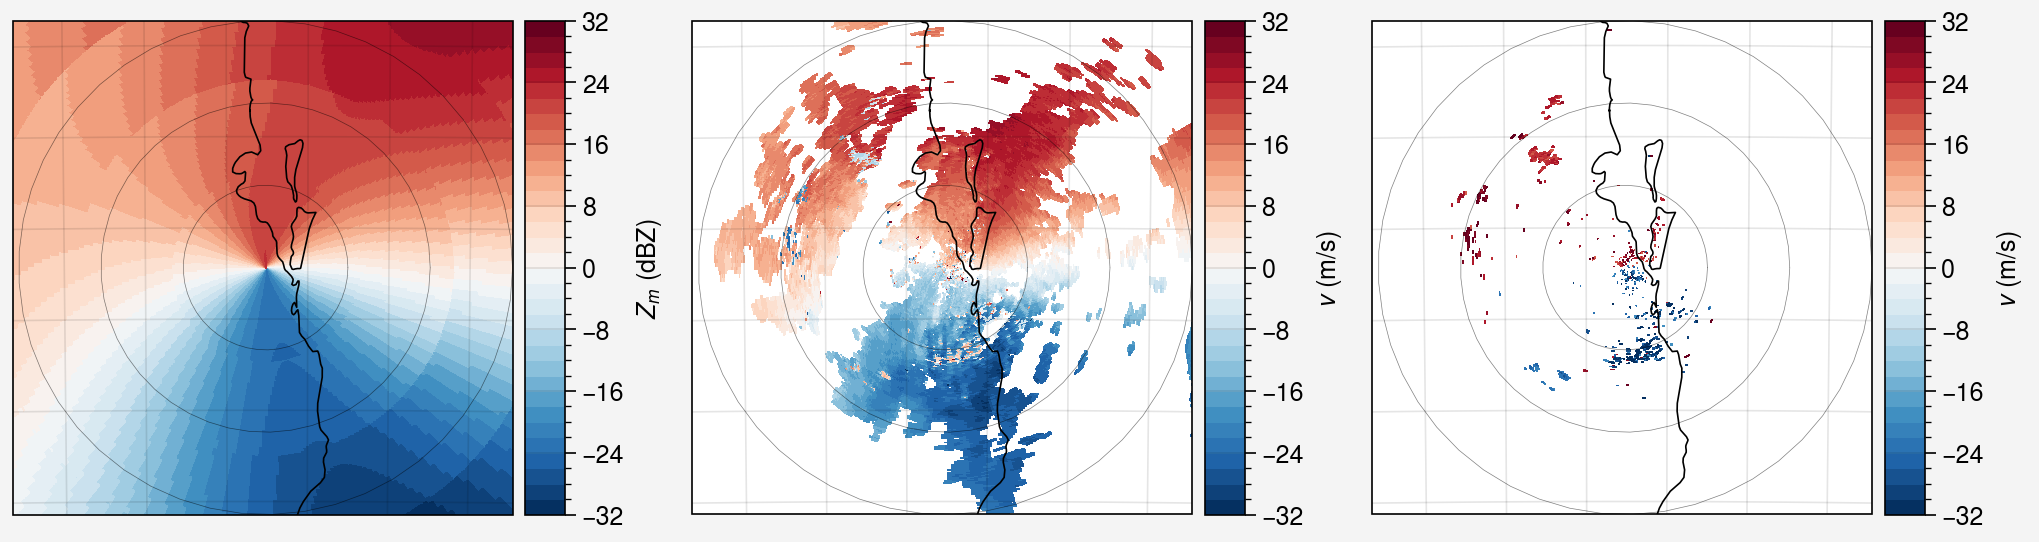

In [9]:
fig = pplt.figure()
axs = fig.subplots(nrows=1, ncols=3, proj="aeqd", proj_kw={"lon_0": lon0, "lat_0":lat0})
im = [None] * len(axs)

vel = np.ma.masked_less(radar.VRADDH, -120)
delta = vr - np.ma.masked_less(radar.VRADDH, -120)

im[0] = axs[0].pcolormesh(radar.longitude, radar.latitude, vr, vmin=-32, vmax=32, levels=40)
im[1] = axs[1].pcolormesh(radar.longitude, radar.latitude, vel, vmin=-32, vmax=32, levels=40)
im[2] = axs[2].pcolormesh(radar.longitude, radar.latitude, np.ma.masked_where(np.abs(delta) < 0.6 * nyquist, delta), vmin=-32, vmax=32, levels=40)
axs[0].colorbar(im[0], label="$Z_m$ (dBZ)")
axs[1].colorbar(im[1], label="$v$ (m/s)")
axs[2].colorbar(im[2], label="$v$ (m/s)")

th = np.linspace(0, 6.28)
for r in [50e3, 100e3, 150e3]:
    x0 = r * np.cos(th)
    y0 = r * np.sin(th)
    xlo, yla = proj(x0, y0, inverse=True)
    axs.plot(xlo, yla, "k", linewidth=.25, alpha=0.5)

axs.format(
    latlim=latlims,
    lonlim=lonlims,
    coast=True,
    reso="hi",
)

pl.show()

In [10]:
# %%time
# nvel = vel.copy()
# for i, j in zip(*np.where(np.abs(vr - nvel) > 0.6 * nyquist)):
#     v = nvel[i, j]
#     if np.abs(v + nyquist - vr[i, j]) < nyquist:
#         nvel[i, j] += nyquist
#     elif np.abs(v - nyquist - vr[i, j]) < nyquist:
#         nvel[i, j] -= nyquist
#     else:
#         ...

In [11]:
%%time
nvel = vel.copy()
for n in [4, 3, 2, 1]:
    pos = np.abs(vr - nvel) > 0.6 * nyquist
    nvelp = nvel + n * nyquist
    nvelm = nvel - n * nyquist
    posp = pos & (np.abs(vr - nvelp) < .6 * nyquist)
    posm = pos & (np.abs(vr - nvelm) < .6 * nyquist)
    nvel[posp] = nvelp[posp]
    nvel[posm] = nvelm[posm]
    print(posp.sum(), posm.sum())

0 0
0 0
10 20
799 930
CPU times: user 92.3 ms, sys: 16.8 ms, total: 109 ms
Wall time: 105 ms


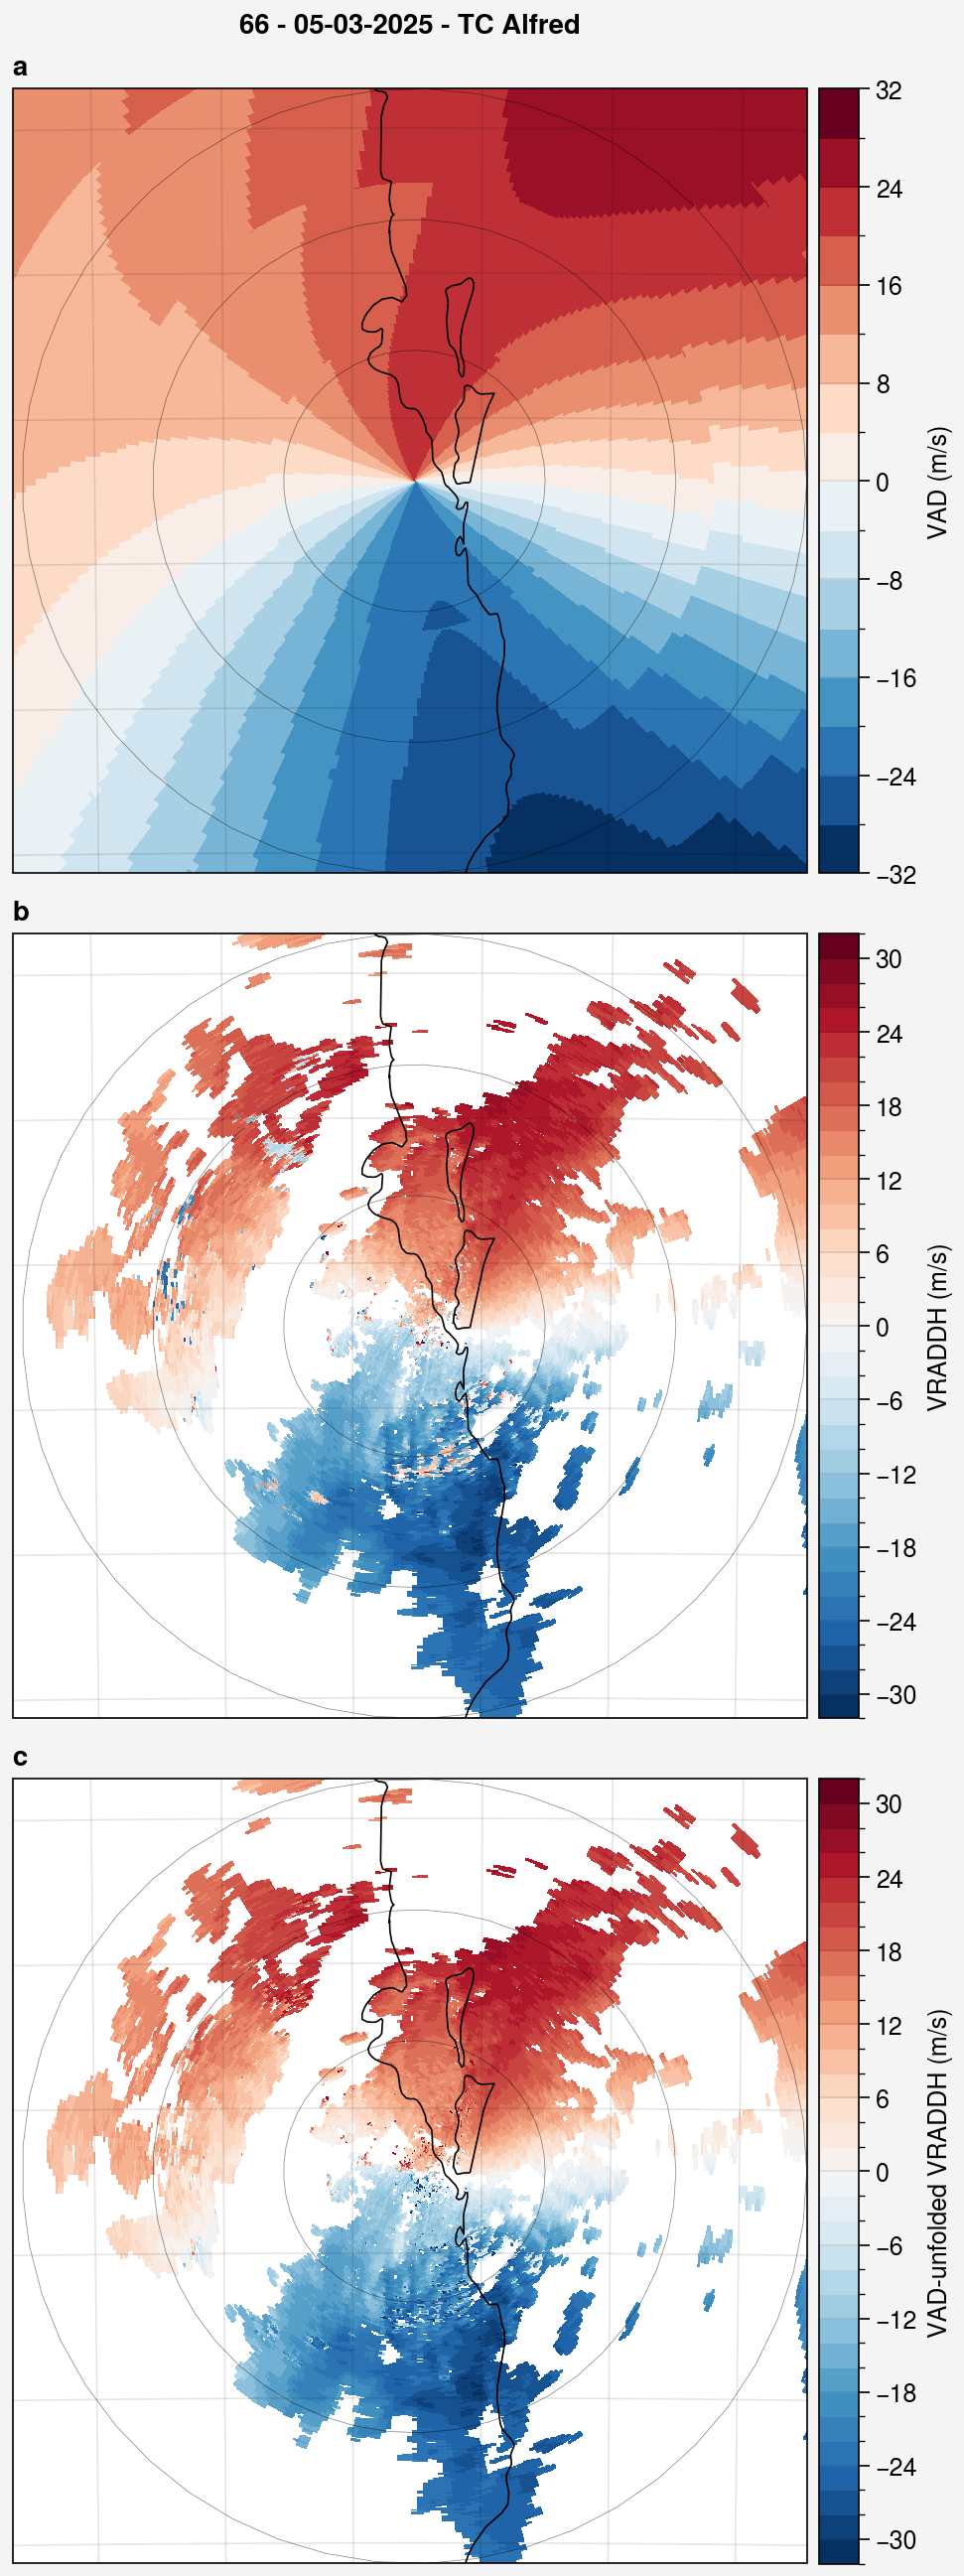

In [12]:
fig = pplt.figure(refwidth=4)
axs = fig.subplots(nrows=3, ncols=1, proj="aeqd", proj_kw={"lon_0": lon0, "lat_0":lat0})
im = [None] * len(axs)

delta = vr - nvel

im[0] = axs[0].pcolormesh(radar.longitude, radar.latitude, vr, vmin=-32, vmax=32, levels=20)
im[1] = axs[1].pcolormesh(radar.longitude, radar.latitude, vel, vmin=-32, vmax=32, levels=40)
im[2] = axs[2].pcolormesh(radar.longitude, radar.latitude, nvel, vmin=-32, vmax=32, levels=40)
axs[0].colorbar(im[0], label="VAD (m/s)")
axs[1].colorbar(im[1], label="VRADDH (m/s)")
axs[2].colorbar(im[2], label="VAD-unfolded VRADDH (m/s)")

th = np.linspace(0, 6.28)
for r in [50e3, 100e3, 150e3]:
    x0 = r * np.cos(th)
    y0 = r * np.sin(th)
    xlo, yla = proj(x0, y0, inverse=True)
    axs.plot(xlo, yla, "k", linewidth=.25, alpha=0.5)

axs.format(
    abc=True,
    suptitle="66 - 05-03-2025 - TC Alfred",
    latlim=latlims,
    lonlim=lonlims,
    coast=True,
    reso="hi",
)

# pl.savefig("vad_tc.png", dpi=250)
pl.show()

In [13]:
@jit
def mean_grad(vel, grad_thres=50.0, daz=6, dr=6):
    na, nr = vel.shape
    dvrdaz = np.zeros((vel.shape))
    for k in range(nr):
        for j in range(na):
            if np.isnan(vel[j, k]):
                dvrdaz[j, k] = np.nan                
                continue
                
            jmin = j - daz
            jmax = j + daz
            kmin = k - dr
            kmax = k + dr

            mean_dvrdaz = 0.
            np_dvrdaz = 0.

            for kk in range(kmin, kmax):
                for jj in range(jmin, jmax):
                    jjgood = jj
                    kkgood = kk
                    if (kk < 0): 
                        kkgood = 0
                    if kk >= nr:
                        kkgood = nr
                    if jj < 0:
                        jjgood = jj + na
                    if jj >= na:
                        jjgood = jj - na

                    if not np.isnan(vel[jjgood, kkgood]) and not np.isnan(vel[jjgood - 1, kkgood]):
                        mean_dvrdaz += (vel[jjgood, kkgood] - vel[jjgood - 1, kkgood]) / (np.pi / 180)
                        np_dvrdaz += 1

            if np_dvrdaz > (2 * daz) * (2 * dr) / 3:
                dvrdaz[j, k] = mean_dvrdaz / np_dvrdaz
            else:
                dvrdaz[j, k] = np.nan
    return dvrdaz

In [14]:
daz = 6
dr = 6

r = radar.range.values
azi = radar.azimuth.values
[R, A] = np.meshgrid(r, azi)
el = radar.elevation.values[0]

cel = np.cos(np.pi / 180 * el)
sel = np.sin(np.pi / 180 * el)
vel = np.ma.masked_less(radar.VRADDH, -120)

In [15]:
dvr = mean_grad(vel.filled(np.nan), grad_thres=50.0, daz=daz, dr=dr)

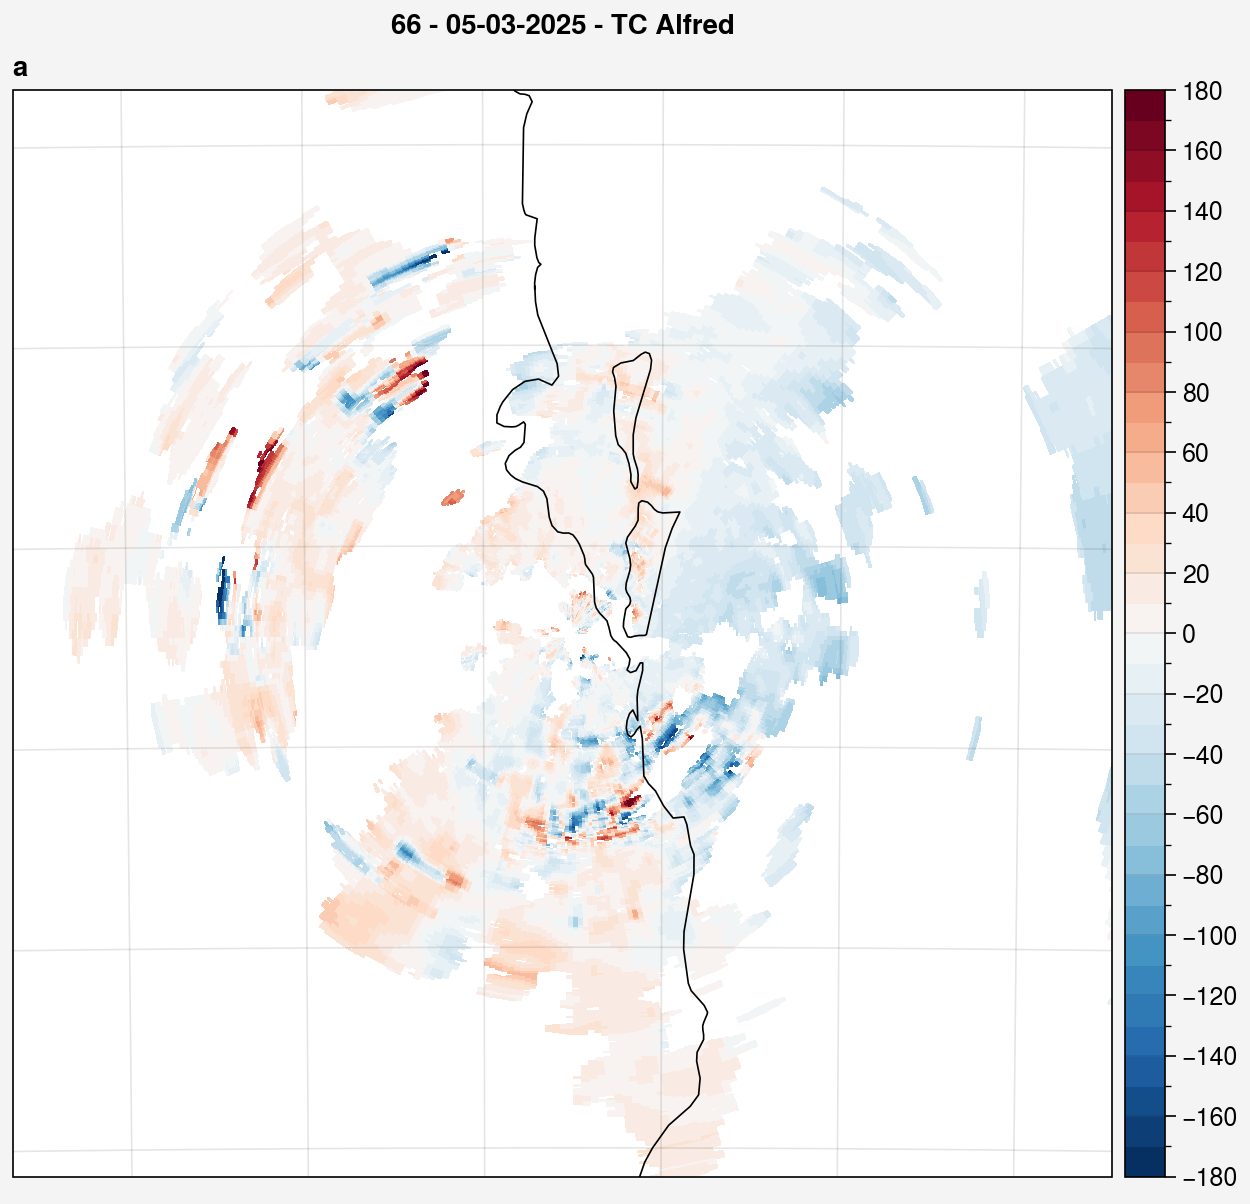

In [16]:
fig = pplt.figure(refwidth=5.5)
axs = fig.subplots(nrows=1, ncols=1, proj="aeqd", proj_kw={"lon_0": lon0, "lat_0":lat0})
im = axs.pcolormesh(radar.longitude, radar.latitude, dvr, vmin=-180, vmax=180, levels=40)
axs.colorbar(im)
axs.format(
    abc=True,
    suptitle="66 - 05-03-2025 - TC Alfred",
    latlim=latlims,
    lonlim=lonlims,
    coast=True,
    reso="hi",
)
pl.show()